# Equations of TISR for substitution alloy. 

# Free energy $f$ is defined as explicit function of thermodynamical variables $\theta = k_B T, P$ and internal variables $\lambda _\mathbf{\sigma}$. 

# Concentrations $x_\mathbf{\sigma}$ are also explicit functions of  $\lambda _\mathbf{\sigma}, (\sigma = 1,2, ... n)$. 

# Every cell is described by parameters $i_\mathbf{\sigma} = i_1, i_2,... i_n$ corresponding to number of atoms of every type  in the cell
\begin{split}
f(\theta, \lambda_\mathbf{\sigma}) &= \theta(1-\gamma) \left( \sum_\mathbf{\sigma}  x_\mathbf{\sigma} \ln x_\mathbf{\sigma} 
- (\sum_\mathbf{\rho} x_\mathbf{\rho} )\ln \sum_\mathbf{\sigma} x_\mathbf{\sigma} \right)
    + \theta \gamma \sum_\mathbf{\sigma}\lambda_\mathbf{\sigma} x_\mathbf{\sigma} \\
   \end{split}

\begin{equation}
p_\mathbf{i} = W_\mathbf{i} \exp(\sum_\mathbf{\sigma} i_\mathbf{\sigma} \lambda_\mathbf{\sigma} ) ; \quad 
W_\mathbf{i} = \sum_\alpha \exp \left(- {\frac{\beta U_{\mathbf{i} \alpha}}{\theta\gamma }}\right) 
\end{equation}
\begin{equation}
\frac{\partial p_\mathbf{i}}{\partial \lambda_\sigma} = i_\sigma p_\mathbf{i}
\end{equation}

\begin{equation}
x_\mathbf{\sigma} = \sum_\mathbf{i} \frac{i_\mathbf{\sigma}}{k}  p_\mathbf{i}; \quad \sum_\mathbf{\sigma} i_\mathbf{\sigma} = k
\end{equation}


# Some abbreviations:

\begin{equation}
S = \sum_\mathbf{i} p_\mathbf{i}; \quad S_\mathbf{\sigma} = \frac{\partial S}{\partial \lambda_\sigma} = \sum_\mathbf{i} i_\mathbf{\sigma} p_\mathbf{i}; \quad
S_\mathbf{\sigma \nu} = \frac{\partial S_\mathbf{\nu}}{\partial \lambda_\sigma}  = \sum_\mathbf{i} i_\mathbf{\sigma} i_\mathbf{\nu} p_\mathbf{i}; \quad
S_\mathbf{\sigma \nu \rho} = \sum_\mathbf{i} i_\mathbf{\sigma} i_\mathbf{\nu} i_\mathbf{\rho} p_\mathbf{i}
\end{equation}

\begin{equation} \sum_\sigma S_\sigma = k S; \quad \sum_\sigma S_{\sigma \nu} = k S_\nu \end{equation} 


#  Variables $\lambda_\sigma$ are not independent, the following constraint has to be enforced:
\begin{equation}
S = \sum_\mathbf{i} p_\mathbf{i} = \sum_\mathbf{i} W_\mathbf{i} \exp(\sum_\mathbf{\sigma} i_\mathbf{\sigma} \lambda_\mathbf{\sigma} ) =1
\end{equation}

# In reality $ i_1 + i_2 = k $. It allows the double sum consider as a single.  We can denote $ V_i = W_{i (k-i)}  \exp(i \lambda_1 + (k-i) \lambda_2)$ Then for Fortran with index starting from 1:

\begin{split}
f &= \theta(1-\gamma) \left( \sum_\mathbf{\nu}  x_\mathbf{\nu} \ln x_\mathbf{\nu} 
- (\sum_\mathbf{\nu} x_\mathbf{\nu} )\ln \sum_\mathbf{\nu} x_\mathbf{\nu} \right)
    + \theta \gamma \sum_\mathbf{\nu}\lambda_\mathbf{\nu} x_\mathbf{\nu} \\
&= \theta (1 - \gamma) \left(\sum_\nu \frac{S_\nu}{k} \ln \frac{S_\nu}{k} 
- S \ln S \right) + \theta \gamma \left(\sum_\nu \frac{S_\nu}{k} \lambda_\nu \right) 
\end{split}


\begin{split}
\frac{\partial f}{\partial \lambda_\sigma} 
&= \theta (1 - \gamma) \left(\sum_\nu \frac{S_{\nu \sigma} }{k} \ln \frac{S_\nu}{k} 
+ \sum_\nu \frac{S_{\nu \sigma} }{k} - S_\sigma \ln S - S_\sigma\right)
+ \frac{ \theta \gamma}{k } \left(\sum_\nu S_{\nu \sigma}  \lambda_\nu + S_\sigma \right)\\
&= \theta (1 - \gamma) \left(\sum_\nu \frac{S_{\nu \sigma} }{k} \ln \frac{S_\nu}{k} 
 - S_\sigma \ln S \right)
+ \frac{ \theta \gamma}{k } \left(\sum_\nu S_{\nu \sigma}  \lambda_\nu + S_\sigma \right)\\
\end{split}

\begin{equation}
\left(\frac{\partial^2 f}{\partial \lambda_\sigma \partial \lambda_\rho} \right) = 
\theta (1 - \gamma) \left(\sum_\nu \frac{S_{\nu \sigma \rho} }{k} \ln \frac{S_\nu}{k} 
+ \sum_\nu \frac{S_{\nu \sigma } }{k S_\nu} S_{\nu \rho}
 - S_{\sigma \rho} \ln S - \frac{S_\sigma S_\rho}{S}\right) 
+ \frac{ \theta \gamma}{k } \left(\sum_\nu S_{\nu \sigma  \rho}  \lambda_\nu + S_{\rho \sigma }
+ S_{\sigma  \rho} \right) 
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wdg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import fsolve
from scipy.special import comb    

In [2]:
k = 4                                    # Size of the cell
n = 3                                    # Number of components
gamma = 4
Akn = comb(k+n-1,k , exact=True) + 1     # Size of array A to be defined  
#print(k+1, Akn, n+1 )

In [3]:
# Every cell must contain k atoms. Construct all possible compositions of cells using algorithm from WEB:
# "Calculating a polynomial in several variables" -- http://www.tvd-home.ru/numerical/polynom 

def set_cells():
    '''Generate list of cells identified by composition '''
    A = np.zeros((k+1, Akn, n+1 ))          # Working array to calculate and collect cells parameters = cells compositions
    Ck = np.zeros(k+1, dtype=np.int16)      # Ck[i] - the index of the last not null element in the line of A[i,,] 
                                            #         corresponding to i atoms in the cell - Working array
    B0 = np.zeros((Akn, n+2), np.float64 )  # Takes last row from A (corresponding to k atoms in a cell) and add a column that will contain W_i
    
    for m0 in np.arange(n):
        m = m0 + 1; 
        for i in np.arange(k):
            if (i==0): 
                Ck[i+1] += 1
                A[i+1,Ck[i+1], m ]  += 1 ; 
            else:
                A[i+1, Ck[i+1]+1 : Ck[i+1] + Ck[i] + 1, :] = A[i, 1 : Ck[i] + 1 , :] + A[1, m:m+1 , :] ; 
                Ck[i+1] += Ck[i]

    B0[:, 1:(n+1)] = A[k, :, 1:(n+1)]
#    print(A[k,:,:])
            
    return B0
B0 = set_cells()
#print(B0)

In [4]:
def set_W(B0, *W):
    ''' Calculate parts of W_i  that do not depend on alloy composition:'''
    # B0 - add W (= statsums of cells) to the last column of B0
    # B1 product of W and every of i_1, i_2,...  : n columns, where i_alpha is number of atoms of type alpha in the cell
    # B2 product of B1 and every of i_1, i_2,... : n*n + 1 columns
    # B3 product of B2 and every of i_1, i_2,... : n*n*n + 1 columns

    B1 = np.zeros((Akn, n + 1), np.float64 )
    B2 = np.zeros((Akn, n*n + 1), np.float64 )
    B3 = np.zeros((Akn, n*n*n + 1), np.float64 )

    if not W :                                  # if W is null create W as a number of permutations for cell of given composition
        fktrl = np.ones(k+1)
        for i in range(k):
            fktrl[i+1] = fktrl[i] * (i+1)

    # Calculating combinatorial factor for every cell == W_i when E_i=0
        for i in range(Akn-1):
            p = 1.
            for j in range(n):
                p *= fktrl[int(B0[i+1, j+1 ])]
        #        print(i+1, j+1, fktrl[n+1] , p, B0[i+1, : ])
                B0[i+1, n+1 ] = fktrl[k] / p
    else:
        B0[i+1, n+1 ] = W[:]                   # if W is supplied

    B1 = B0[:, 1:(n+1)] * B0[:, (n+1):]
    
    i0 = 1
    for i in range(n):
        i2 = i0 + n
        B2[:,i0:i2] = B1[:, :] * B0[:, (i+1):(i+2)]
        i0 = i2

    i0 = 1
    for i in range(n):
        i2 = i0 + n*n
        B3[:,i0:i2] = B2[:, 1:] * B0[:, (i+1):(i+2)]
        i0 = i2

    return B0, B1, B2, B3

B0, B1, B2, B3 = set_W(B0)

#print(B0, B1, B2, B3)

# Calculate all Products $a_1^{i_1} * a_2^{i_2}$... with $ i_1 + i_2 + ... = k$ using the same order as $W_{\mathbf{i}} = B0$

In [5]:
def calc_Si(ai):
    '''Calculate all sums that are defined in the preambule as S, S1, S2, S3 - expressions with specified number of indexes'''
    # ai is array of a1, a2, ...
    C = np.zeros((k+1, Akn ))               # working array 
    Ck = np.zeros(k+1, dtype=np.int16)      # Ck[i] - the index of the last not null element in the line of C[i,] corresponding to i atoms in the cell
    #m = 1 ; 

    # Calculate array C that will contain expressions a1**i1 * a2**i2 ... with i1, i2,... according cell composition
    # Using the same algorithm as in set_cells(). Result put in Ctr array (one column)
    # Every column in B1, B2, B3 multiply by Ctr
    for m0 in np.arange(n):
        m = m0 + 1; #print("m=", m)
        for i in np.arange(k):
            if (i==0): 
                Ck[i+1] += 1
                C[i+1,Ck[i+1]]  = ai[m] ; #print(i+1,Ck[i+1], m)
            else:
                C[i+1, Ck[i+1]+1 : Ck[i+1] + Ck[i] + 1] = C[i, 1 : Ck[i] + 1 ] * ai[m] ; 
                Ck[i+1] += Ck[i]

    #         print(C[i+1, :], -16,i+1)
    #         print("Ck=", Ck)

    S = sum(B0[:,n+1]*C[k, :] )
    Ctr = np.transpose(C[k:(k+1), :])
#    print(Ctr)
    S1 = (B1*Ctr).sum(axis=0)
    S2 = (B2*Ctr).sum(axis=0)
    S3 = (B3*Ctr).sum(axis=0)
#     print(C[k, :], -21, k)
#     print("Ck=", Ck[k])   
#     print("S =",S)
#     print(S1, "= S1",); print(S1.sum())
#     print(S2, "= S2",); print(S2.sum())
#     print(S3, "= S3",); print(S3.sum())
    return S, S1, S2, S3

ai =([0,.2,.3, .5])
(S, S1, S2, S3) = calc_Si(ai)
#print(S, S1, S2, S3)

In [6]:
    print(S1, "= S1",); print(S1.sum())
    print(S2, "= S2",); print(S2.sum())
    print(S3, "= S3",); print(S3.sum())


[ 0.8  1.2  2. ] = S1
4.0
[ 0.    1.28  0.72  1.2   0.72  2.28  1.8   1.2   1.8   5.  ] = S2
16.0
[  0.      2.432   1.008   1.68    1.008   1.152   0.72    1.68    0.72
   2.4     1.008   1.152   0.72    1.152   5.088   2.88    0.72    2.88
   3.6     1.68    0.72    2.4     0.72    2.88    3.6     2.4     3.6    14.   ] = S3
64.0


In [10]:

def lambd2f(lambd, S, S1):
    sum_S1_lambd = sum(S1*lambd)
#    print("sum_S1_lambd =", sum_S1_lambd)

    ln_S1_2k = np.log(S1/k)

    sum_S1_ln_S1 = sum(S1*ln_S1_2k)
#    print(S1, "= S1")
#     print("sum_S1_ln_S1 =", sum_S1_ln_S1)
#     print(gamma*sum_S1_lambd /k)

    f = (1 - gamma)*(sum_S1_ln_S1 / k - S*np.log(S))  + gamma*sum_S1_lambd /k 
    return f

#print(lambd2f(lambd, S, S1))

def lambd2df(lambd, S, S1, S2):
    ln_S1_2k = np.log(S1/k)
    T2 = S2[1:].reshape(n,n)
#     print(T2, "= T2"); print(T2[1,1], "= T2[1,1]")
#     print(np.log(S1/k))
    sum_S2_ln_S1 = np.matmul(T2, ln_S1_2k)
    sum_S2_lambd = np.matmul(T2, lambd)
#    print(sum_S2_ln_S1, "= sum_S2_ln_S1")
#    print(sum_S2_lambd, "= sum_S2_lambd")

    df_TO_dlambd = (1-gamma)*(sum_S2_ln_S1 / k  - S1*np.log(S))   + gamma *(sum_S2_lambd + S1 ) / k
#    print(df_TO_dlambd, "= df_TO_dlambd")
#     print(df_TO_dlambd[1])
    return df_TO_dlambd

def df2_TO_dlambd2(lambd, S, S1, S2, S3 ):
    ln_S1_2k = np.log(S1/k)
#    print(ln_S1_2k, "= ln_S1_2k")
    T2 = S2[1:].reshape(n,n)
    T3 = S3[1:].reshape(n, n, n)
#    print(T3, "=T3")
    T3_2 = np.zeros((n, n)) ;  
    for i in np.arange(n):
        T3_2[i,:] = np.matmul(T3[i,:,:], ln_S1_2k)


    T2_2 = np.zeros((n,n))    
    for i in np.arange(n):
        for j in np.arange(n):
            if (i <= j):
                s = 0
                for l in np.arange(n):
                    s += T2[i, l]*T2[j, l] / S1[l]
                T2_2[i, j] = s
                if (i < j): 
                    T2_2[j, i] = s

    sum_S3_lambd = np.zeros((n, n))        
    for i in np.arange(n):
        sum_S3_lambd[i, :] = np.matmul(T3[i, :, :], lambd)
#        print(T3[i, :, :], "= T3[i, :, :]")

#     print(lambd, "= lambd")
#     print(sum_S3_lambd, "= sum_S3_lambd")
#     print(T2, "= T2")
#     print(T3[i, :, :], "= T3[i, :, :]")
    return (1 - gamma)*(T3_2 / k + T2_2 / k - T2 * np.log(S) - np.outer(S1, S1) / S )   + gamma *(sum_S3_lambd + T2*2 ) / k   

lambd = np.log(ai[1:])
# print(ai[1:], "= ai[1:]")
# print(lambd, "= lambd")
# print(lambd, lambd2df(lambd, S, S1, S2))
# print(df2_TO_dlambd2(lambd, S, S1, S2, S3 ))

[-1.60943791 -1.2039728  -0.69314718] = lambd0


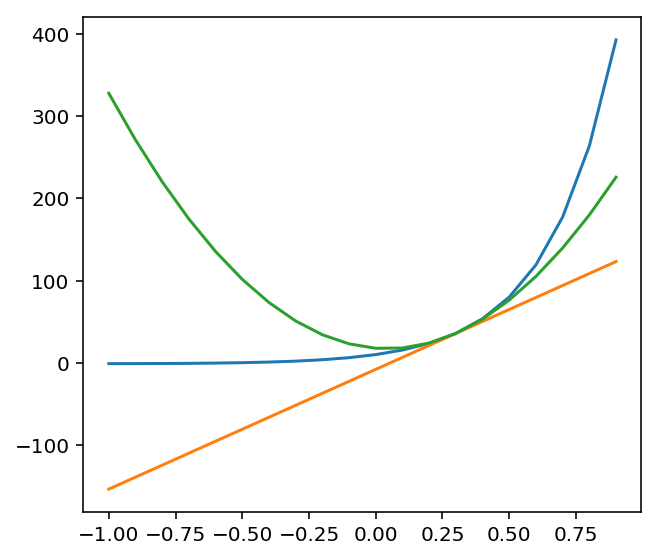

In [16]:
a0 =([0,.2,.3, .5])                  # Point through which we get a section
ai = a0                              # One of the points on section

lmb_i0_arr = np.zeros(20)            # set of values for the component i0 for which f_r has to be calculated
f_r = np.zeros(20)                   # corresponding free energy 
f_tang = np.zeros(20)                # values from tangential line 
f_df2 = np.zeros(20)                 # values for parabolic line
l1_min = -1
l1_max = 1

def extr_f(a0, i0, lmb_i0_tngt):
# i0       the component number that will be varying
# lmb_i0_tngt is the value of component with index i0 that defines where tanget will be constructed.
# if a0 = ([0,.2,.3, .5]) , i0 = 2 and lmb_i0_tngt = 0.6 the tanget will be created for point =([0,.2, .6, .5])  
    lambd0 = np.log(a0[1:]); print(lambd0, "= lambd0")   # lambd0 - point on f(lambd) where we drive a tanget
    lambd0[i0 - 1] = lmb_i0_tngt
    ai[i0] = np.exp(lambd0[i0 - 1])
#     print(i0, "= i0")
    
#     print(lambd0, "=lambd0")
#     print(lmb_i0_tngt, "= lmb_i0_tngt")
    
    (S, S1, S2, S3) = calc_Si(ai)
    f_r_tang = lambd2f(lambd0, S, S1)
#    print(f_r_tang, "= f_r_tang")
    
    df_TO_dlambd0 = lambd2df(lambd0, S, S1, S2)
#    print(df_TO_dlambd0, "= df_TO_dlambd0")
    
    df2 = df2_TO_dlambd2(lambd0, S, S1, S2, S3 )
    
    ll1 = np.linspace(l1_min , l1_max, 21)
    for i in np.arange(20):
        lmb_i0_arr[i] = lambd0[i0 - 1] = ll1[i]
        ai[i0] = np.exp(lambd0[i0 - 1])
#        print(ai, "= ai")
        (S, S1, S2, S3) = calc_Si(ai)
        f_r[i]= lambd2f(lambd0, S, S1)
        delt = (lambd0[i0 -1] - lmb_i0_tngt)
        f_tang[i] = f_r_tang + delt * df_TO_dlambd0[i0 -1]
        f_df2[i] = f_tang[i] + delt *delt * df2[i0 -1, i0 - 1] / 2
#         print(delt, "= delt")
#         print(f_df2[i] , "= f_df2[i] ")
    
#    print(lambdi, "= lambdi")
#    print(f_r, "= f_r")
    fig = plt.figure(figsize=(5,10))
    fig.add_subplot(211)
#    plt.ylim(-20, 10)
    plt.plot(lmb_i0_arr, f_r)
    plt.plot(lmb_i0_arr, f_tang)
    plt.plot(lmb_i0_arr, f_df2)
    plt.show()

extr_f(a0, 2, 0.3)
#print(b1_min0, b1_max0)
# gamma = wdg.FloatSlider(min=4., max=6, value = 4.88 )
# x1 = wdg.FloatSlider(min=0, max=1, value = 0.25, step = 0.01)           
# T = wdg.FloatSlider(min=1, max=2.5, value = 1.88, step = 0.01)          #T is theta/J 
# wdg.interactive(extr_f,gamma=gamma, x1=x1, T=T)